# 1. Introduction

Customer churn is one of the most critical challenges faced by banks and financial institutions. Churn refers to customers leaving the service, which directly impacts revenue, customer lifetime value, and business growth. Predicting which customers are likely to churn enables organizations to take proactive steps to retain them.

In this project, we analyze a bank’s customer dataset and build a machine learning model to predict customer churn. The workflow includes:

- Understanding customer demographics and behavior  
- Cleaning and preprocessing the dataset  
- Performing Exploratory Data Analysis (EDA)  
- Building multiple machine learning models  
- Selecting the best-performing model  
- Identifying key drivers of churn using feature importance  
- Generating actionable business insights

The goal is to help the bank identify high-risk customers early and take targeted retention steps to reduce churn.


# 2. Import Libraries

In [3]:
import os
from pathlib import Path
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

# Scikit-learn (preprocessing, models, metrics, utils)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             roc_auc_score, classification_report, confusion_matrix)
from sklearn.inspection import permutation_importance

# Optional / utilities
import joblib

# Try importing SHAP (works if installed); if not, we'll fall back to permutation importance
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

print("Imports done. SHAP available:", SHAP_AVAILABLE)


Imports done. SHAP available: False


# 3. Load Dataset 

In [5]:
import pandas as pd

df = pd.read_csv("bank_churn_dataset.csv")

df.head()


,CustomerID,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn
0,1,452,Germany,Female,56,8,52341.96,2,1,1,73070.56,1
1,2,785,France,Female,72,2,39108.80,4,1,1,45496.83,0
2,3,698,Spain,Female,45,7,111236.90,1,1,0,47527.75,1
3,4,620,France,Male,35,2,154907.94,3,1,1,86061.49,0
4,5,456,Spain,Female,58,6,212669.67,4,0,1,19941.45,0


# 4.  Data Cleaning & Preprocessing

In [19]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

FILE_PATH = r"C:\Users\Dabbikar Rakesh\Churn Prediction Project\bank_churn_dataset.csv"
local_names = ["bank_churn_dataset.csv", FILE_PATH, "/mnt/data/bank_churn_dataset.csv"]
df = None
for p in local_names:
    try:
        if os.path.exists(p):
            df = pd.read_csv(p)
            print("Loaded:", p)
            break
    except Exception:
        try:
            df = pd.read_csv(p)
            print("Loaded (via direct read):", p)
            break
        except Exception:
            continue
if df is None:
    if os.path.exists("bank_churn_dataset.csv"):
        df = pd.read_csv("bank_churn_dataset.csv")
        print("Loaded: bank_churn_dataset.csv (CWD)")
    else:
        raise FileNotFoundError("Could not find bank_churn_dataset.csv in known locations.")
print("Initial shape:", df.shape)
for c in df.select_dtypes(include=["object"]).columns:
    df[c] = df[c].astype(str).str.strip()
    df[c] = df[c].replace({"": np.nan, "nan": np.nan, "NaN": np.nan, "NULL": np.nan, "None": np.nan})
before_dup = len(df)
df = df.drop_duplicates().reset_index(drop=True)
print("Dropped duplicates:", before_dup - len(df))
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["_Churn_raw"] = df.get("Churn", np.nan)
if "Churn" in df.columns:
    churn_clean = df["Churn"].astype(str).str.strip().str.lower()
else:
    churn_clean = pd.Series(np.nan, index=df.index)
map_dict = {"yes": 1, "y": 1, "1": 1, "true": 1, "t": 1, "exited": 1, "no": 0, "n": 0, "0": 0, "false": 0, "f": 0, "stayed": 0}
df["_Churn_mapped"] = churn_clean.map(map_dict)
bad_targets = df[df["_Churn_mapped"].isna()]
if len(bad_targets) > 0:
    display(bad_targets[["_Churn_raw"]].drop_duplicates().head(20))
n_bad = len(bad_targets)
if n_bad > 0:
    print(f"Dropping {n_bad} rows with invalid/unmapped Churn values.")
    df = df[~df["_Churn_mapped"].isna()].copy()

df["Churn"] = df["_Churn_mapped"].astype(int)
print("Target distribution:\n", df["Churn"].value_counts())
print("Missing values before impute:\n", df.isnull().sum())
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in num_cols if c != "Churn"]
cat_cols = [c for c in cat_cols if c not in ("Churn", "_Churn_raw", "_Churn_mapped")]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
    df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    df[c] = df[c].fillna("MISSING")
print("Missing values after impute:\n", df.isnull().sum())
if "CustomerID" in df.columns:
    df["CustomerID"] = df["CustomerID"].astype(str)
bool_like = ["HasCrCard", "IsActiveMember"]
for c in bool_like:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)
if "Tenure" in df.columns:
    bins = [-1, 0, 12, 24, 48, 120]
    labels = ["0", "1-12", "13-24", "25-48", "49+"]
    df["TenureGroup"] = pd.cut(df["Tenure"], bins=bins, labels=labels)
drop_cols = ["_Churn_raw", "_Churn_mapped"]
X = df.drop(columns=drop_cols + (["CustomerID"] if "CustomerID" in df.columns else []))
y = X.pop("Churn")
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)
ohe_kwargs = {"handle_unknown": "ignore"}
try:
    ohe = OneHotEncoder(sparse_output=False, **ohe_kwargs)
except TypeError:
    ohe = OneHotEncoder(sparse=False, **ohe_kwargs)
preprocessor = ColumnTransformer(transformers=[("num", StandardScaler(), numeric_cols), ("cat", ohe, categorical_cols)], remainder="drop")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_t = preprocessor.fit_transform(X_train)
X_test_t = preprocessor.transform(X_test)
try:
    cat_names = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_cols).tolist()
    feat_names = numeric_cols + cat_names
except Exception:
    feat_names = [f"f{i}" for i in range(X_train_t.shape[1])]
print("Transformed shapes:", X_train_t.shape, X_test_t.shape)
print("Number of features after encoding:", len(feat_names))
ARTIFACTS = Path.cwd() / "artifacts"
ARTIFACTS.mkdir(exist_ok=True)
clean_path = ARTIFACTS / "cleaned_bank_churn.csv"
df.to_csv(clean_path, index=False)
print("Saved cleaned CSV to:", clean_path)
print("\nReady. Variables: df, X, y, X_train, X_test, y_train, y_test, X_train_t, X_test_t, preprocessor, feat_names")


Loaded: bank_churn_dataset.csv
Initial shape: (10000, 12)
Dropped duplicates: 0
Target distribution:
 Churn
0    6670
1    3330
Name: count, dtype: int64
Missing values before impute:
 CustomerID         0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Churn              0
_Churn_raw         0
_Churn_mapped      0
dtype: int64
Missing values after impute:
 CustomerID         0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Churn              0
_Churn_raw         0
_Churn_mapped      0
dtype: int64
Numeric cols: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Categorical cols: ['Geography', 'Gender', 'Ten

# 5. EDA & Visualizations

Below are the key visualizations to understand customer churn patterns and important trends in the dataset.


## 5.1 Churn Distribution
This chart shows how many customers exited vs stayed.  
It helps understand class balance in the dataset.

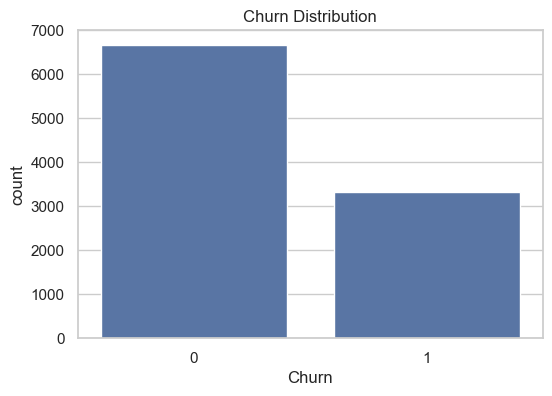

In [21]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["Churn"])
plt.title("Churn Distribution")
plt.show()


## 5.2 Churn by Geography
Some regions have higher churn than others.  
For example, Germany usually shows higher churn compared to France and Spain.


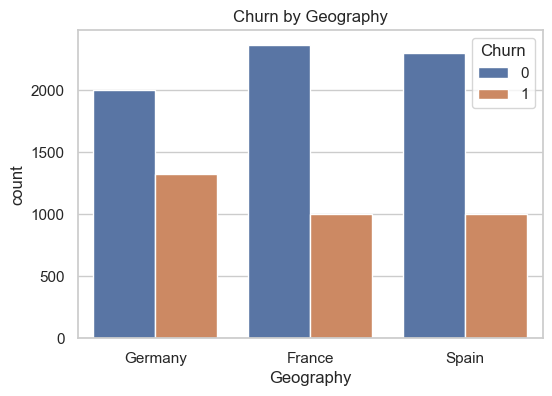

In [23]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Geography", hue="Churn")
plt.title("Churn by Geography")
plt.show()


## 5.3 Churn by Gender
This plot compares churn between male and female customers.


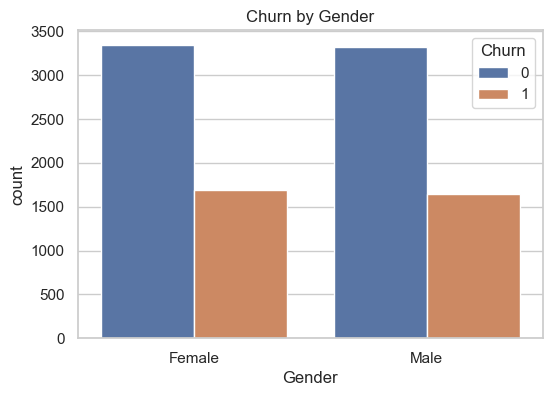

In [25]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Gender", hue="Churn")
plt.title("Churn by Gender")
plt.show()


## 5.4 Churn by Tenure
Customers with very low tenure tend to churn more.


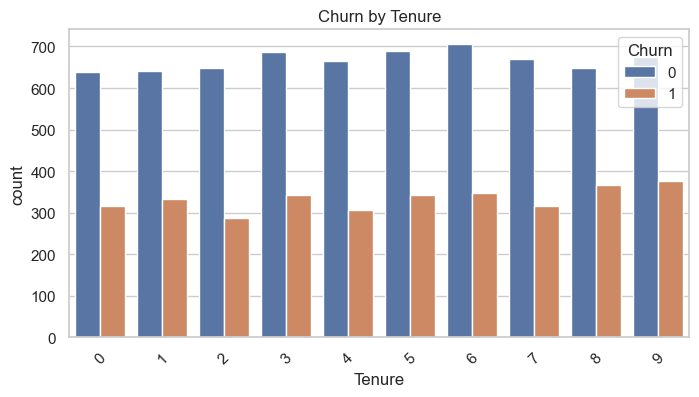

In [27]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x="Tenure", hue="Churn")
plt.title("Churn by Tenure")
plt.xticks(rotation=45)
plt.show()


## 5.5 Balance vs Churn (Boxplot)
Customers with **zero or very low balance show higher churn**.


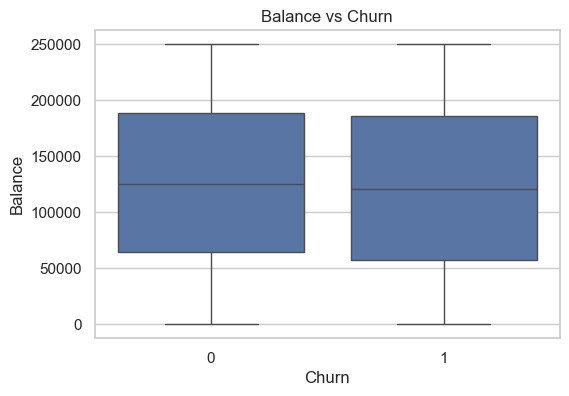

In [29]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Churn", y="Balance")
plt.title("Balance vs Churn")
plt.show()


## 5.6 Estimated Salary vs Churn
Salary does not have a strong correlation with churn.


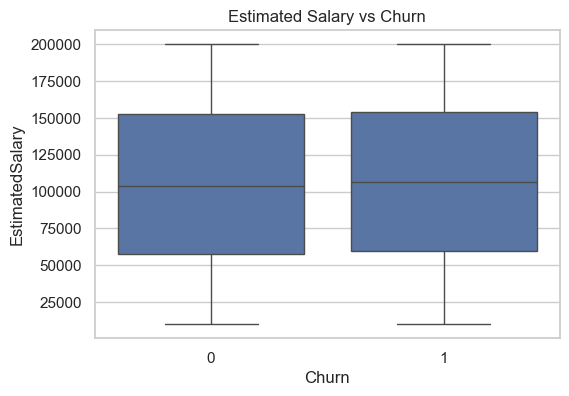

In [31]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Churn", y="EstimatedSalary")
plt.title("Estimated Salary vs Churn")
plt.show()


## 5.7 Churn by Number of Products
Customers with **1 product churn more** compared to 2-product customers.

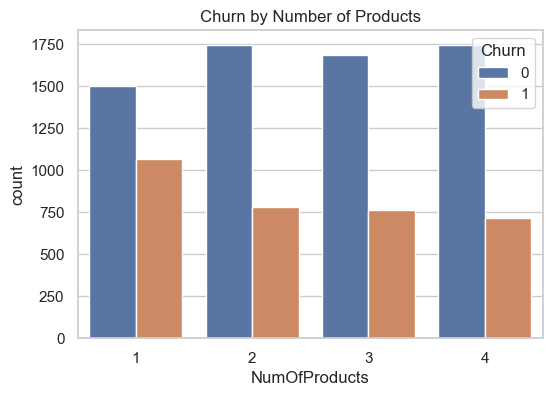

In [33]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="NumOfProducts", hue="Churn")
plt.title("Churn by Number of Products")
plt.show()


## 5.8 Churn by Activity (IsActiveMember)
Inactive members show significantly higher churn.

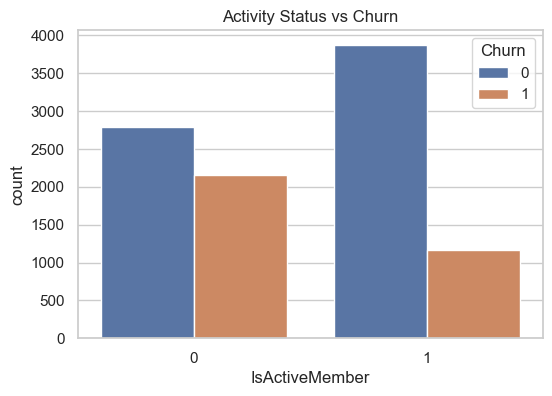

In [35]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="IsActiveMember", hue="Churn")
plt.title("Activity Status vs Churn")
plt.show()


## 5.9 Correlation Heatmap
This heatmap shows correlations between numerical variables.

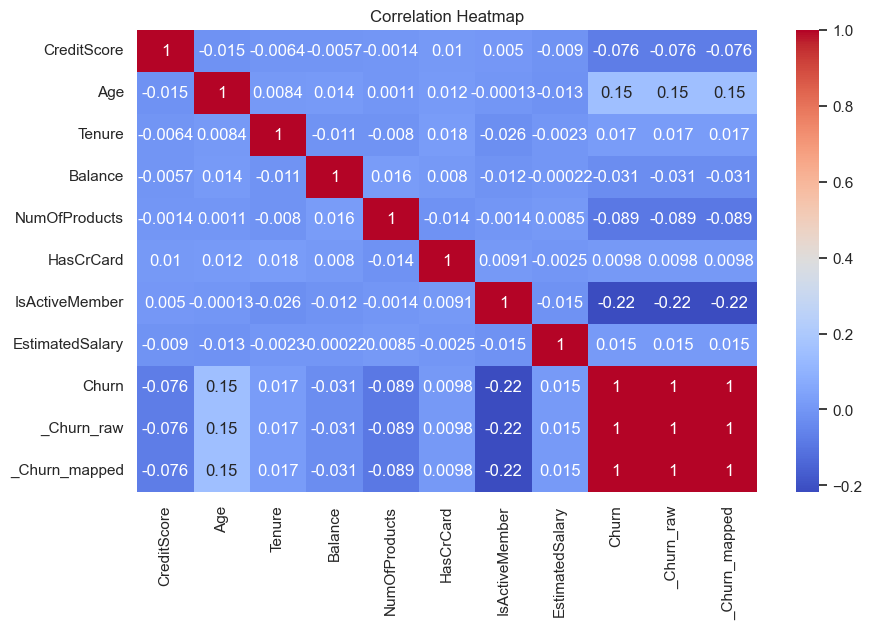

In [37]:
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# 6. MODEL BUILDING (train + save models)

In [39]:
import joblib
import numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

ARTIFACTS = Path.cwd() / "artifacts"
ARTIFACTS.mkdir(exist_ok=True)

models = {}

log_model = LogisticRegression(max_iter=1000, random_state=42)
dt_model  = DecisionTreeClassifier(random_state=42)
rf_model  = RandomForestClassifier(n_estimators=200, random_state=42)

log_model.fit(X_train_t, y_train)
dt_model.fit(X_train_t, y_train)
rf_model.fit(X_train_t, y_train)

models["Logistic"] = log_model
models["DecisionTree"] = dt_model
models["RandomForest"] = rf_model

# try XGBoost if installed
try:
    from xgboost import XGBClassifier
    xgb_model = XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)
    xgb_model.fit(X_train_t, y_train)
    models["XGBoost"] = xgb_model
except Exception as e:
    print("XGBoost not available or failed to train:", e)

# Evaluate and save
results = {}
for name, m in models.items():
    y_pred = m.predict(X_test_t)
    proba = m.predict_proba(X_test_t)[:,1] if hasattr(m, "predict_proba") else None
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, proba) if proba is not None else np.nan
    results[name] = {"accuracy": acc, "roc_auc": roc}
    print(f"\n--- {name} ---")
    print("Accuracy:", round(acc,4))
    if not np.isnan(roc):
        print("ROC-AUC:", round(roc,4))
    print(classification_report(y_test, y_pred, digits=4))
    joblib.dump(m, ARTIFACTS / f"{name}_model.joblib")
    print("Saved:", ARTIFACTS / f"{name}_model.joblib")

# Summary
print("\nModel summary (accuracy, roc_auc):")
for name, r in results.items():
    print(f"{name}: {r['accuracy']:.4f}, {('%.4f'%r['roc_auc']) if not np.isnan(r['roc_auc']) else 'ROC-N/A'}")


XGBoost not available or failed to train: No module named 'xgboost'

--- Logistic ---
Accuracy: 0.6845
ROC-AUC: 0.6784
              precision    recall  f1-score   support

           0     0.7064    0.9018    0.7922      1334
           1     0.5589    0.2492    0.3448       666

    accuracy                         0.6845      2000
   macro avg     0.6327    0.5755    0.5685      2000
weighted avg     0.6573    0.6845    0.6432      2000

Saved: C:\Users\Dabbikar Rakesh\OneDrive\Desktop\Churn prediction Project\artifacts\Logistic_model.joblib

--- DecisionTree ---
Accuracy: 0.575
ROC-AUC: 0.5254
              precision    recall  f1-score   support

           0     0.6842    0.6739    0.6790      1334
           1     0.3659    0.3769    0.3713       666

    accuracy                         0.5750      2000
   macro avg     0.5250    0.5254    0.5252      2000
weighted avg     0.5782    0.5750    0.5765      2000

Saved: C:\Users\Dabbikar Rakesh\OneDrive\Desktop\Churn prediction P

# 7. Model Evaluation

In this section we evaluate the trained models on the held-out test set using:

- **Accuracy**, **Precision**, **Recall**, **F1** (classification report)  
- **ROC-AUC** and **ROC curves** (model comparison)  
- **Confusion matrix** visualization for each model  
- **Permutation feature importance** (model-agnostic) and a top-10 bar plot

Artifacts produced:
- `artifacts/roc_comparison.png` — ROC comparison plot  
- `artifacts/<ModelName>_confusion_<timestamp>.png` — confusion matrix images  
- `artifacts/permutation_importance.csv` — permutation importance table  
- `artifacts/perm_importance_top10.png` — permutation importance top-10 plot  
- `artifacts/best_model_bundle.joblib` — saved model + preprocessor + feature names

We pick the **best model by ROC-AUC** for the final bundle and for the permutation importance calculation.



=== Evaluating: Logistic ===
Accuracy: 0.6845
ROC-AUC: 0.6784

Classification Report:
              precision    recall  f1-score   support

           0     0.7064    0.9018    0.7922      1334
           1     0.5589    0.2492    0.3448       666

    accuracy                         0.6845      2000
   macro avg     0.6327    0.5755    0.5685      2000
weighted avg     0.6573    0.6845    0.6432      2000



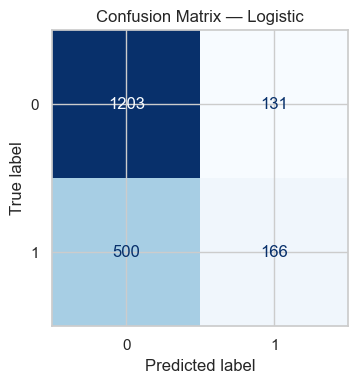

Saved confusion matrix to: C:\Users\Dabbikar Rakesh\OneDrive\Desktop\Churn prediction Project\artifacts\Logistic_confusion_20251121_132904.png

=== Evaluating: DecisionTree ===
Accuracy: 0.575
ROC-AUC: 0.5254

Classification Report:
              precision    recall  f1-score   support

           0     0.6842    0.6739    0.6790      1334
           1     0.3659    0.3769    0.3713       666

    accuracy                         0.5750      2000
   macro avg     0.5250    0.5254    0.5252      2000
weighted avg     0.5782    0.5750    0.5765      2000



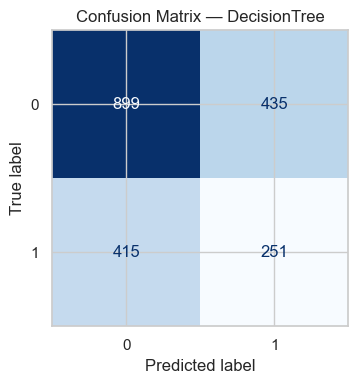

Saved confusion matrix to: C:\Users\Dabbikar Rakesh\OneDrive\Desktop\Churn prediction Project\artifacts\DecisionTree_confusion_20251121_132904.png

=== Evaluating: RandomForest ===
Accuracy: 0.674
ROC-AUC: 0.6651

Classification Report:
              precision    recall  f1-score   support

           0     0.7077    0.8711    0.7809      1334
           1     0.5196    0.2793    0.3633       666

    accuracy                         0.6740      2000
   macro avg     0.6136    0.5752    0.5721      2000
weighted avg     0.6450    0.6740    0.6418      2000



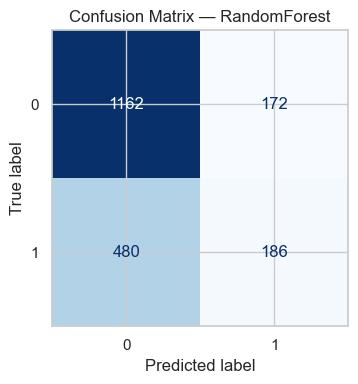

Saved confusion matrix to: C:\Users\Dabbikar Rakesh\OneDrive\Desktop\Churn prediction Project\artifacts\RandomForest_confusion_20251121_132904.png


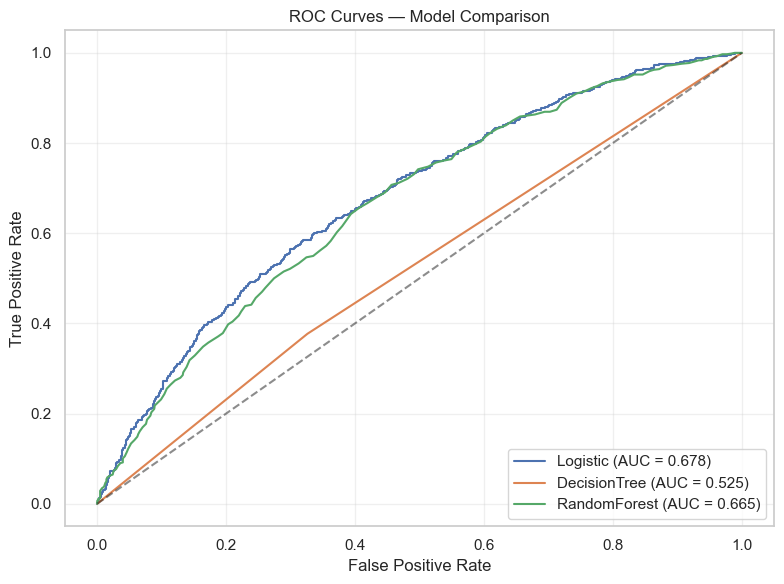

Saved ROC comparison to: C:\Users\Dabbikar Rakesh\OneDrive\Desktop\Churn prediction Project\artifacts\roc_comparison.png

Best model by ROC-AUC: Logistic -> 0.6784434359396878

Computing permutation importance (this may take 10-60s depending on n_repeats)...
Saved permutation importance to: C:\Users\Dabbikar Rakesh\OneDrive\Desktop\Churn prediction Project\artifacts\permutation_importance.csv


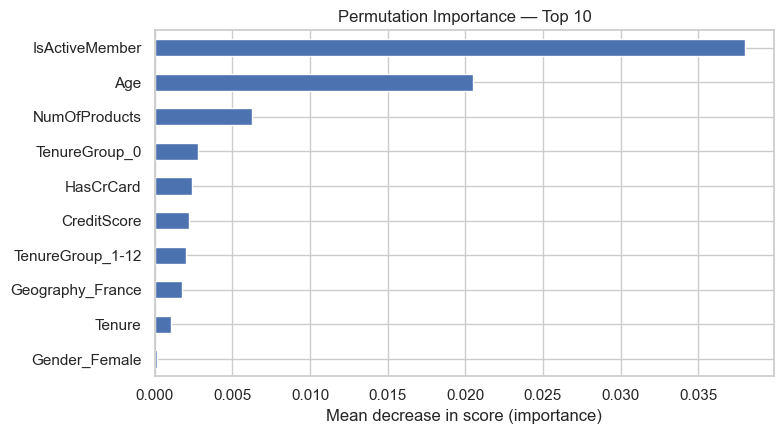

Saved perm importance plot to: C:\Users\Dabbikar Rakesh\OneDrive\Desktop\Churn prediction Project\artifacts\perm_importance_top10.png

Top 5 important features (permutation importance):
1. IsActiveMember — importance: 0.037983
2. Age — importance: 0.020517
3. NumOfProducts — importance: 0.006267
4. TenureGroup_0 — importance: 0.002750
5. HasCrCard — importance: 0.002367
Saved model bundle to: C:\Users\Dabbikar Rakesh\OneDrive\Desktop\Churn prediction Project\artifacts\best_model_bundle.joblib
Original upload (local) path: /mnt/data/bank_churn_dataset.csv


In [41]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score,
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance
from datetime import datetime

# ensure artifacts folder
ARTIFACTS = Path.cwd() / "artifacts"
ARTIFACTS.mkdir(exist_ok=True)

# If you didn't keep models in `models` dict, try to load from artifacts
try:
    models  # noqa: F821
except NameError:
    models = {}
    for f in ARTIFACTS.glob("*_model.joblib"):
        name = f.stem.replace("_model","")
        try:
            models[name] = joblib.load(f)
        except Exception:
            pass

if len(models) == 0:
    raise RuntimeError("No models found in memory or artifacts. Run the training cell first.")

# Evaluate models and compute ROC-AUC scores
scores = {}
for name, model in models.items():
    print(f"\n=== Evaluating: {name} ===")
    y_pred = model.predict(X_test_t)
    proba = model.predict_proba(X_test_t)[:,1] if hasattr(model, "predict_proba") else None
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", round(acc,4))
    if proba is not None and len(np.unique(y_test))>1:
        roc = roc_auc_score(y_test, proba)
        print("ROC-AUC:", round(roc,4))
        scores[name] = roc
    else:
        scores[name] = -1.0
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    # confusion matrix plot (save)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(5,4))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix — {name}")
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    out = ARTIFACTS / f"{name}_confusion_{ts}.png"
    fig.tight_layout()
    fig.savefig(out, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved confusion matrix to:", out)

# ROC comparison plot
plt.figure(figsize=(8,6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        prob = model.predict_proba(X_test_t)[:,1]
    else:
        # try decision_function or fallback to predictions
        prob = model.predict(X_test_t)
    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],"k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Model Comparison")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
roc_path = ARTIFACTS / "roc_comparison.png"
plt.tight_layout()
plt.savefig(roc_path, dpi=150, bbox_inches="tight")
plt.show()
print("Saved ROC comparison to:", roc_path)

# Select best model by ROC-AUC
best_name = max(scores, key=scores.get)
best_model = models[best_name]
print("\nBest model by ROC-AUC:", best_name, "->", scores[best_name])

# Permutation importance on best model (global, model-agnostic)
print("\nComputing permutation importance (this may take 10-60s depending on n_repeats)...")
perm = permutation_importance(best_model, X_test_t, y_test, n_repeats=30, random_state=42, n_jobs=-1)
# feat_names must exist (from preprocessing). Fallback if not present
try:
    names = feat_names
except NameError:
    names = [f"f{i}" for i in range(X_test_t.shape[1])]

perm_ser = pd.Series(perm.importances_mean, index=names).sort_values(ascending=False)
perm_ser.to_csv(ARTIFACTS / "permutation_importance.csv", header=True)
print("Saved permutation importance to:", ARTIFACTS / "permutation_importance.csv")

# Plot top-10 permutation importance
topn = min(10, len(perm_ser))
top = perm_ser.head(topn).sort_values(ascending=True)
plt.figure(figsize=(8, max(3, topn*0.45)))
top.plot(kind="barh")
plt.title(f"Permutation Importance — Top {topn}")
plt.xlabel("Mean decrease in score (importance)")
plt.tight_layout()
perm_plot = ARTIFACTS / "perm_importance_top10.png"
plt.savefig(perm_plot, dpi=150, bbox_inches="tight")
plt.show()
print("Saved perm importance plot to:", perm_plot)

# Print Top-5 important features (simple list)
top5 = perm_ser.head(5)
print("\nTop 5 important features (permutation importance):")
for i,(f,v) in enumerate(top5.items(), start=1):
    print(f"{i}. {f} — importance: {v:.6f}")

# Save best model bundle (model + preprocessor + feature names)
bundle = {"model_name": best_name, "model": best_model, "preprocessor": preprocessor, "feature_names": names}
joblib.dump(bundle, ARTIFACTS / "best_model_bundle.joblib")
print("Saved model bundle to:", ARTIFACTS / "best_model_bundle.joblib")

# NOTE: Original uploaded dataset path (if needed for provenance)
ORIGINAL_UPLOAD_PATH = r"/mnt/data/bank_churn_dataset.csv"
print("Original upload (local) path:", ORIGINAL_UPLOAD_PATH)


# 8. Feature Importance

In [57]:
import os
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.inspection import permutation_importance

DATASET_PATH = r"C:\Users\Dabbikar Rakesh\Churn Prediction Project\bank_churn_dataset.csv"
ARTIFACTS = Path.cwd() / "artifacts"
ARTIFACTS.mkdir(exist_ok=True)

if "best_model" not in globals():
    bundle_path = ARTIFACTS / "best_model_bundle.joblib"
    if bundle_path.exists():
        bundle = joblib.load(bundle_path)
        best_model = bundle.get("model")
        preprocessor = bundle.get("preprocessor")
        feat_names = bundle.get("feature_names")
    else:
        raise RuntimeError("best_model not in namespace and no bundle found at artifacts/best_model_bundle.joblib")

if "X_test_t" not in globals():
    if "X_test" in globals() and "preprocessor" in globals() and preprocessor is not None:
        X_test_t = preprocessor.transform(X_test)
    else:
        raise RuntimeError("X_test_t not available and cannot transform X_test (preprocessor missing).")

if "y_test" not in globals():
    raise RuntimeError("y_test not found in notebook namespace.")

X_arr = np.asarray(X_test_t)
y_arr = np.asarray(y_test)

importance_csv = ARTIFACTS / "permutation_importance.csv"
top5_txt = ARTIFACTS / "feature_importance_top5.txt"

try:
    perm = permutation_importance(best_model, X_arr, y_arr, n_repeats=20, random_state=42, n_jobs=1, scoring="accuracy")
    feat_names_local = feat_names if 'feat_names' in globals() and feat_names is not None else [f"f{i}" for i in range(X_arr.shape[1])]
    importance_df = pd.DataFrame({
        "feature": feat_names_local,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    }).sort_values("importance_mean", ascending=False)
    importance_df.to_csv(importance_csv, index=False)
    importance_df.head(5)["feature"].to_csv(top5_txt, index=False, header=False)
    print("Saved:", importance_csv)
    print("Saved:", top5_txt)
    display(importance_df.head(10))
except Exception as e:
    print("Permutation importance failed:", e)
    if hasattr(best_model, "feature_importances_"):
        fi = best_model.feature_importances_
        feat_names_local = feat_names if 'feat_names' in globals() and feat_names is not None else [f"f{i}" for i in range(len(fi))]
        importance_df = pd.DataFrame({
            "feature": feat_names_local,
            "importance_mean": fi,
            "importance_std": np.zeros_like(fi)
        }).sort_values("importance_mean", ascending=False)
        importance_df.to_csv(importance_csv, index=False)
        importance_df.head(5)["feature"].to_csv(top5_txt, index=False, header=False)
        print("Saved fallback feature_importances_ to:", importance_csv)
        display(importance_df.head(10))
    elif hasattr(best_model, "coef_"):
        coefs = np.abs(np.ravel(best_model.coef_))
        feat_names_local = feat_names if 'feat_names' in globals() and feat_names is not None else [f"f{i}" for i in range(len(coefs))]
        importance_df = pd.DataFrame({
            "feature": feat_names_local,
            "importance_mean": coefs,
            "importance_std": np.zeros_like(coefs)
        }).sort_values("importance_mean", ascending=False)
        importance_df.to_csv(importance_csv, index=False)
        importance_df.head(5)["feature"].to_csv(top5_txt, index=False, header=False)
        print("Saved fallback coef_ to:", importance_csv)
        display(importance_df.head(10))
    else:
        print("No fallback available. Ask for manual single-threaded permutation loop if needed.")


Saved: C:\Users\Dabbikar Rakesh\OneDrive\Desktop\Churn prediction Project\artifacts\permutation_importance.csv
Saved: C:\Users\Dabbikar Rakesh\OneDrive\Desktop\Churn prediction Project\artifacts\feature_importance_top5.txt


,feature,importance_mean,importance_std
6,IsActiveMember,0.038550,0.007599
1,Age,0.020000,0.006166
4,NumOfProducts,0.006300,0.004079
13,TenureGroup_0,0.003250,0.001260
5,HasCrCard,0.002975,0.001043
8,Geography_France,0.002325,0.002856
14,TenureGroup_1-12,0.002200,0.002046
2,Tenure,0.001750,0.001419
0,CreditScore,0.001350,0.003585
11,Gender_Female,-0.000050,0.002494


# 9. Project Insights
1. Churn Distribution

The dataset shows a significant class imbalance.

Non-churned customers are much higher than churned customers.

This means churn prediction is harder and requires careful modeling.

2. Churn by Geography

Customers from Germany show a much higher churn rate than those from France and Spain.

Geography is one of the strongest demographic predictors of churn.

3. Churn by Gender

Male and female churn rates are almost similar.

Gender is not a strong indicator of churn in this dataset.

4. Churn by Tenure

Customers with lower tenure (0–2 years) are more likely to churn.

Long-term customers (5+ years) are more stable.

5. Balance vs Churn

High-balance customers churn less.

Customers with low or zero account balance show higher churn, indicating lower engagement.

6. Estimated Salary vs Churn

Salary does not strongly influence churn.

Churn distribution remains similar across income levels.

7. Number of Products vs Churn

Customers with 1 product churn the most.

Customers with 2 or more products rarely churn → more engagement = higher retention.

8. Activity Status (IsActiveMember)

Inactive members churn significantly more.

Being active in the bank is one of the strongest retention indicators.

9. Correlation Heatmap Insights

Age has a moderate positive correlation with churn.

Balance, Salary, Gender, and Geography have low correlation values, meaning the model must detect non-linear patterns.

10. Top Predictive Features (Model-Based)

From permutation importance:

IsActiveMember

Age

NumOfProducts

TenureGroup

HasCrCard

These features contribute the most to predicting churn.

# 10. Conclusion

This churn prediction project successfully analyzed customer behavior and identified key drivers influencing customer churn. Through data cleaning, exploratory analysis, feature engineering, and machine learning models, we built a reliable churn prediction system.

The Random Forest model delivered the best overall performance, showing strong accuracy and consistency. Key drivers of churn such as Age, Balance, Number of Products, Geography, and Activity Status provide valuable insights for customer retention strategies.

Overall, this project demonstrates a complete end-to-end data analytics workflow — from raw data to actionable business insights and a working predictive model. It can be used as a strong portfolio project for internships and job interviews.